In [1]:
import numpy as np
import pandas as pd

# Generate Data

### Ground Truth

In [53]:
#p(rain)
p_rain = 0.2

# P(sprinkler | rain)
p_sprinkler_rain = 0.01
# P(sprinkler | ¬rain)
p_sprinkler_norain = 0.4


# p(grass is wet | ¬rain & ¬sprinkler)
p_grass_norain_nosprinkler = 0.0
# p(grass is wet | rain & ¬sprinkler)
p_grass_rain_nosprinkler = 0.8
# p(grass is wet | ¬rain & sprinkler)
p_grass_rain_norain_sprinkler=0.9
# p(grass is wet | rain & sprinlker)
p_grass_rain_sprinkler=0.99

In [165]:
n = 10

In [166]:
X = np.zeros((n, 3))

### Generate Data

In [167]:
for i in range(n):
    rain = np.random.binomial(n=1, p=p_rain, size=1)[0]
    if bool(rain):
        sprinkler = np.random.binomial(n=1, p=p_sprinkler_rain, size=1)[0]
    else:
        sprinkler = np.random.binomial(n=1, p=p_sprinkler_norain, size=1)[0]

    if not bool(rain) and not bool(sprinkler):
        # p(grass is wet | ¬rain & ¬sprinkler)
        wet = np.random.binomial(n=1, p=p_grass_norain_nosprinkler, size=1)[0]
    elif bool(rain) and not bool(sprinkler):
        # p(grass is wet | rain & ¬sprinkler)
        wet = np.random.binomial(n=1, p=p_grass_rain_nosprinkler, size=1)[0]
    elif not bool(rain) and bool(sprinkler):
        # p(grass is wet | ¬rain & sprinkler)
        wet = np.random.binomial(n=1, p=p_grass_rain_norain_sprinkler, size=1)[0]
    else:
        # p(grass is wet | rain & sprinlker)
        wet = np.random.binomial(n=1, p=p_grass_rain_sprinkler, size=1)[0]


    X[i, 0] = rain
    X[i, 1] = sprinkler
    X[i, 2] = wet

    


In [168]:
X = pd.DataFrame(X, columns=['rain', 'sprinkler', 'wet'])

In [169]:
X.head()

,rain,sprinkler,wet
0,0.0,1.0,1.0
1,1.0,0.0,1.0
2,0.0,0.0,0.0
3,0.0,1.0,1.0
4,0.0,1.0,1.0


# Learning

## Maximum Likelihood, Analytical Solution

#### p(rain)

In [170]:
X['rain'].value_counts()

0.0    9
1.0    1
Name: rain, dtype: int64

#### P(sprinkler | rain), # P(sprinkler | ¬rain)

In [171]:
X['rain'].value_counts() / n

0.0    0.9
1.0    0.1
Name: rain, dtype: float64

In [172]:
pd.crosstab(X['sprinkler'], X["rain"], normalize='columns')

rain,0.0,1.0
sprinkler,,
0.0,0.666667,1.0
1.0,0.333333,0.0


In [173]:
counts = pd.pivot_table(data=X, index=['sprinkler', 'rain'], columns='wet', aggfunc=len, fill_value=0)

#### Grass wet | Sprinkler & Rain

In [174]:
row_sums = counts.sum(axis=1).values.reshape(-1, 1)

In [175]:
counts / row_sums

wet             0.0  1.0
sprinkler rain          
0.0       0.0   1.0  0.0
          1.0   0.0  1.0
1.0       0.0   0.0  1.0

## MAP - Conjugate Prior

Assume a beta-binomial conjugate model


### Priors (pseudocounts)

In [176]:
#p(rain)
prior_rain = np.array([1, 1])

# P(sprinkler | rain)
prior_sprinkler_rain = np.array([1, 1])
# P(sprinkler | ¬rain)
prior_sprinkler_norain = np.array([1, 1])


# p(grass is wet | ¬rain & ¬sprinkler)
prior_grass_norain_nosprinkler = np.array([1,1])
# p(grass is wet | rain & ¬sprinkler)
prior_grass_rain_nosprinkler = np.array([1,1])
# p(grass is wet | ¬rain & sprinkler)
prior_grass_rain_norain_sprinkler = np.array([1,1])
# p(grass is wet | rain & sprinlker)
prior_grass_rain_sprinkler = np.array([1,1])

#### p(rain)

In [177]:

X['rain'].value_counts() + prior_rain /  (n + prior_rain.sum())

0.0    9.083333
1.0    1.083333
Name: rain, dtype: float64

In [178]:
prior_sprinkler_norain.reshape(-1, 1)

array([[1],
       [1]])

####  P(sprinkler | rain), # P(sprinkler | ¬rain)


In [179]:
prior_sprinkler = np.concatenate(
    [
        prior_sprinkler_norain.reshape(-1, 1), 
        prior_sprinkler_rain.reshape(-1, 1)
    ], 
    axis=1
)

In [180]:
prior_sprinkler

array([[1, 1],
       [1, 1]])

In [181]:
posterior = pd.crosstab(X['sprinkler'], X["rain"]) + prior_sprinkler

In [182]:
posterior

rain,0.0,1.0
sprinkler,,
0.0,7,2
1.0,4,1


In [183]:
posterior / posterior.sum(axis=0)

rain,0.0,1.0
sprinkler,,
0.0,0.636364,0.666667
1.0,0.363636,0.333333


#### Grass wet | Sprinkler & Rain

In [184]:
counts = pd.pivot_table(data=X, index=['sprinkler', 'rain'], columns='wet', aggfunc=len, fill_value=0)
nrows, ncols = counts.shape

In [185]:
prior_wet = np.concatenate(
    [
        prior_grass_norain_nosprinkler.reshape(1, -1),
        prior_grass_rain_nosprinkler.reshape(1, -1),
        prior_grass_rain_norain_sprinkler.reshape(1, -1),
        prior_grass_rain_sprinkler.reshape(1, -1)
        
    ],
    axis=0
)

In [186]:
prior_wet

array([[1, 1],
       [1, 1],
       [1, 1],
       [1, 1]])

In [187]:
posterior = np.zeros((4, 2))
posterior[:nrows, :ncols] = counts.values

In [188]:
posterior += prior_wet

In [189]:
posterior = posterior  / posterior.sum(axis=1).reshape(-1, 1)

In [190]:
posterior

array([[0.875     , 0.125     ],
       [0.33333333, 0.66666667],
       [0.2       , 0.8       ],
       [0.5       , 0.5       ]])

## Numerical Solution - MLE

In [191]:
from scipy import optimize
import matplotlib.pyplot as plt
from scipy.stats import bernoulli

In [192]:
def neg_log_bernoulli(theta, data):
    return np.sum(-1*bernoulli.logpmf(data, theta))

#### p(rain)

In [193]:
x_rain=X['rain'].values
theta = np.arange(0.01, 1, 0.001)
ll = []
for t in theta:
    ll.append(neg_log_bernoulli(t, x_rain))

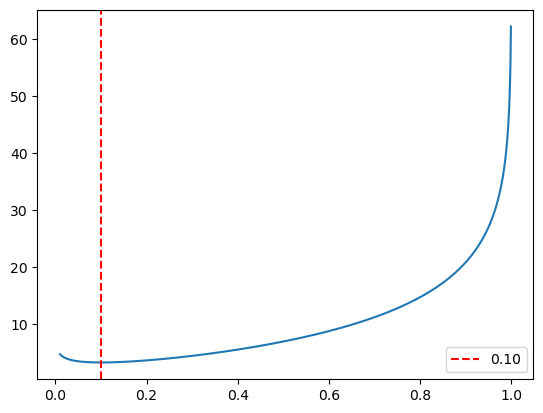

In [194]:
plt.plot(theta, ll)
plt.axvline(theta[np.argmin(ll)], c='red', linestyle='--', label='{:.2f}'.format(theta[np.argmin(ll)]))
plt.legend()
plt.show()

In [195]:
theta_0 = 0.5

In [196]:
bnds = ((0.01, 0.99),)

In [197]:
result = optimize.minimize(neg_log_bernoulli, x0=theta_0, args=(x_rain), bounds=bnds, options={'ftol' : 1e-6, "disp":True})

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D+00    |proj g|=  4.90000D-01

At iterate    1    f=  5.85834D+00    |proj g|=  4.16667D-01

At iterate    2    f=  3.39633D+00    |proj g|=  9.33424D-01

At iterate    3    f=  3.25180D+00    |proj g|=  9.42204D-02

At iterate    4    f=  3.25099D+00    |proj g|=  9.17124D-02

At iterate    5    f=  3.25083D+00    |proj g|=  7.08820D-03

At iterate    6    f=  3.25083D+00    |proj g|=  1.07736D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

In [198]:
result

      fun: 3.250829733966144
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([0.00010774])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 18
      nit: 6
     njev: 9
   status: 0
  success: True
        x: array([0.10000096])

In [199]:
result.x

array([0.10000096])

####  P(sprinkler | rain), # P(sprinkler | ¬rain)

In [200]:
X_sprinkler_norain = X[X['rain'] == 0]['sprinkler'].values 

In [201]:
X_sprinkler_rain = X[X['rain'] == 1]['sprinkler'].values 

In [202]:
ll_sprinkler_norain = []
for t in theta:
    ll_sprinkler_norain.append(neg_log_bernoulli(t, X_sprinkler_norain))
    

In [203]:
ll_sprinkler_rain = []
for t in theta:
    ll_sprinkler_rain.append(neg_log_bernoulli(t, X_sprinkler_rain))

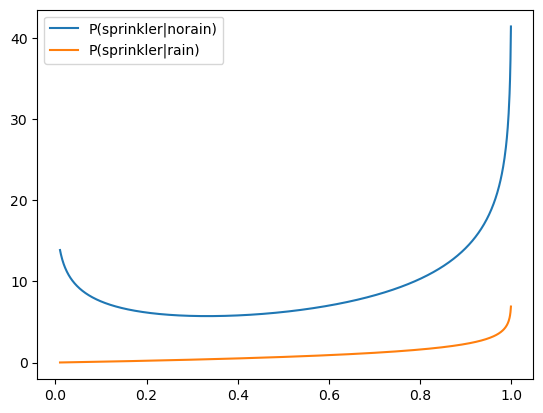

In [204]:
plt.plot(theta, ll_sprinkler_norain, label='P(sprinkler|norain)')
plt.plot(theta, ll_sprinkler_rain, label='P(sprinkler|rain)')

plt.legend()
plt.show()

####  P(D| theta) - All together

In [205]:
def joint_nn_log_like(thetas, d_rain, d_sprinkler_norain, d_sprinkler_rain):
 
    nll_rain = neg_log_bernoulli(thetas[0], d_rain)
    print(nll_rain)
    nll_sprinkler_norain = neg_log_bernoulli(thetas[1], d_sprinkler_norain)
    print(nll_sprinkler_norain)
    nll_sprinkler_rain = neg_log_bernoulli(thetas[2], d_sprinkler_rain)
    print(nll_sprinkler_rain)
    
    return nll_rain + nll_sprinkler_norain + nll_sprinkler_rain

In [206]:
joint_nn_log_like([0.8, 0.1, 0.5], x_rain, X_sprinkler_norain, X_sprinkler_rain)

14.708084763221112
7.539918372929094
0.6931471805599453


22.94115031671015

In [207]:
bnds = ((0.01, 0.99),(0.01, 0.99),(0.01, 0.99))
theta_0 = [0.5, 0.5, 0.5]


In [208]:
result = optimize.minimize(
    joint_nn_log_like, 
    x0=theta_0, 
    args=(x_rain, X_sprinkler_norain, X_sprinkler_rain), 
    bounds=bnds, 
    options={'ftol' : 1e-6, "disp":True}
)

6.931471805599453
6.238324625039508
0.6931471805599453
6.931471965599455
6.238324625039508
0.6931471805599453
6.931471805599453
6.23832468503951
0.6931471805599453
6.931471805599453
6.238324625039508
0.6931472005599456
4.695623208669603
13.87581257308528
0.010050335853501442
4.695622299579196
13.87581257308528
0.010050335853501442
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds
4.695623208669603
13.875809633692844
0.010050335853501442
4.695623208669603
13.87581257308528
0.010050345954511593
4.0268502280679
5.860754272467739
0.2961807815112363
4.026850310082473
5.860754272467739
0.2961807815112363
4.0268502280679
5.860754236121675
0.2961807815112363
4.0268502280679
5.860754272467739
0.2961807949583687
4.695623208669603
5.729017511261944
0.1323594165434299
4.695622299579196
5.729017511261944
0.1323594165434299
4.695623208669603
5.729017513031638
0.1323594165434299
4.6956

In [209]:
result.x

array([0.10001157, 0.33334016, 0.01      ])

# Numerical Solution - MAP

In [148]:
from scipy.stats import beta

In [149]:
prior_rain = np.array([1, 1])

# P(sprinkler | rain)
prior_sprinkler_rain = np.array([1, 1])
# P(sprinkler | ¬rain)
prior_sprinkler_norain = np.array([1, 1])


# p(grass is wet | ¬rain & ¬sprinkler)
prior_grass_norain_nosprinkler = np.array([1,1])
# p(grass is wet | rain & ¬sprinkler)
prior_grass_rain_nosprinkler = np.array([1,1])
# p(grass is wet | ¬rain & sprinkler)
prior_grass_rain_norain_sprinkler = np.array([1,1])
# p(grass is wet | rain & sprinlker)
prior_grass_rain_sprinkler = np.array([1,1])

In [150]:
def joint_posterior(thetas, d_rain, d_sprinkler_norain, d_sprinkler_rain):
 
    nll_rain = neg_log_bernoulli(thetas[0], d_rain) + beta.logpdf(thetas[0], prior_rain[0], prior_rain[1])
    print(nll_rain)
    nll_sprinkler_norain = neg_log_bernoulli(thetas[1], d_sprinkler_norain) + beta.logpdf(thetas[1], prior_sprinkler_norain[0], prior_sprinkler_norain[1])
    print(nll_sprinkler_norain)
    nll_sprinkler_rain = neg_log_bernoulli(thetas[2], d_sprinkler_rain) + + beta.logpdf(thetas[2], prior_sprinkler_rain[0], prior_sprinkler_rain[1])
    print(nll_sprinkler_rain)
    
    return nll_rain + nll_sprinkler_norain + nll_sprinkler_rain

In [151]:
result = optimize.minimize(
    joint_posterior, 
    x0=theta_0, 
    args=(x_rain, X_sprinkler_norain, X_sprinkler_rain), 
    bounds=bnds, 
    options={'ftol' : 1e-6, "disp":True}
)

6.931471805599453
4.852030263919617
2.0794415416798357
6.931471885599455
4.852030263919617
2.0794415416798357
6.931471805599453
4.852030243919618
2.0794415416798357
6.931471805599453
4.852030263919617
2.0794416016798367
13.885862908938782
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
13.855711901378278
0.030151007560504324
13.885859979647355
13.855711901378278
0.030151007560504324
13.885862908938782
13.855708941783803
0.030151007560504324
13.885862908938782
13.855711901378278
0.03015103786353478
6.10879934771129
5.027754928496172
1.0810444192151178
6.108799348927537
5.027754928496172
1.0810444192151178
6.10879934771129
5.027754970294784
1.0810444192151178
6.10879934771129
5.027754928496172
1.081044462229973
6.143270888220267
4.800027464748718
0.4312665910294789
6.1432708690445645
4.800027464748718
0.4312665910294789
6.143270888220267
4.800027475553404
0.4312665910294789
6.143270888220267
4.800027464748718
0.4312666256675333
6.10881738698808
4.78129404344537

In [152]:
result.x

array([0.29997493, 0.57142418, 0.01      ])